Tutorial for ptychography reconstructions with CDTools
======================================================

This tutorial runs through a few basic ptychography reconstruction scenarios
using cdtools in a jupyter notebook. Before running it, you should run

```
$ bash setup.sh
```

In order to install the appropriate conda environment. This will take 2-5 minutes
to install. Then, launch the notebook using the 'ptycho-tutorial' kernel. 

Further resources and information about how to use and install cdtools can be
found at the following links:

* [CDTools docs](https://cdtools-developers.github.io/cdtools/)
* [CDTools Github page](https://github.com/cdtools-developers/cdtools)

Feel free to get in contact with any questions!

Author:  
Abraham Levitan  
abraham.levitan@psi.ch

In [1]:
# Necessary imports
%matplotlib inline
from matplotlib import pyplot as plt
import cdtools
import torch as t

# Definitions to find data
tutorial_data_folder = '/global/cfs/cdirs/als/gsharing/bl701/PtychoTutorial/'

Loading and viewing data
------------------------

Data which is stored in a compliant '.cxi' file can be loaded using the
`Ptycho2DDataset.from_cxi(<filename>)` factory function.

The ptychography data can then be directly viewed using the `dataset.inspect()`
function, which produces a set of two plots - the average diffraction pattern, and
a small widget which shows the full diffraction data. On the right hand side of
the widget are diffraction patterns. The left-hand side of the widget shows
a plot of the scan points for the dataset, with the color of each dot corresponding
to the summed intensity of the associated diffraction pattern.

When run in a script or in an interactive shell, one can click on individual scan
points to see the associated diffraction pattern.

Let's look at the example below, using a classic publicly available ptychography
dataset which was collected at the ALS' COSMIC Imaging branch many years ago:
[https://cxidb.org/id-65.html](https://cxidb.org/id-65.html)

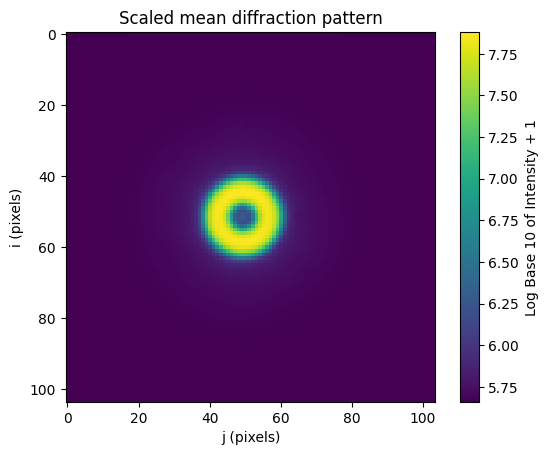

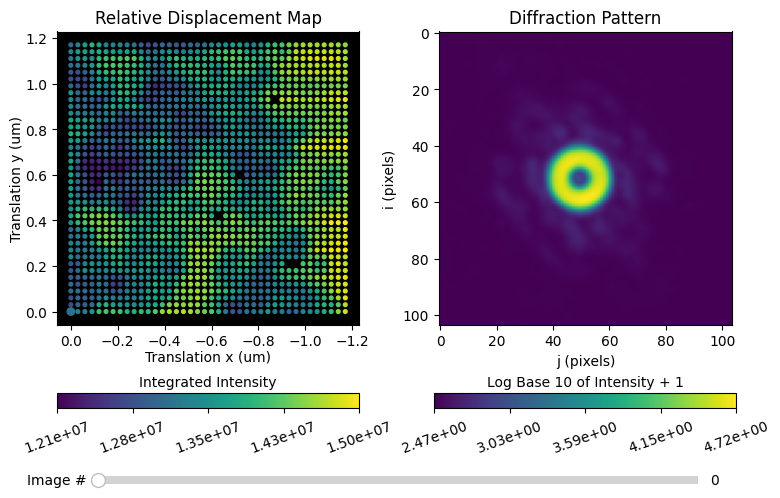

In [4]:
# Loading and viewing a dataset
au_balls_dataset = cdtools.datasets.Ptycho2DDataset.from_cxi(
    tutorial_data_folder + 'AuBalls_700ms_30nmStep_3_6SS_filter.cxi')
au_balls_dataset.inspect()
plt.show()

Let's also load two other datasets. First, let's look at a ptychography dataset
collected using a pinhole and optical light on an optical test bench. This one
looks very different! Note the option to change the default plotting units:

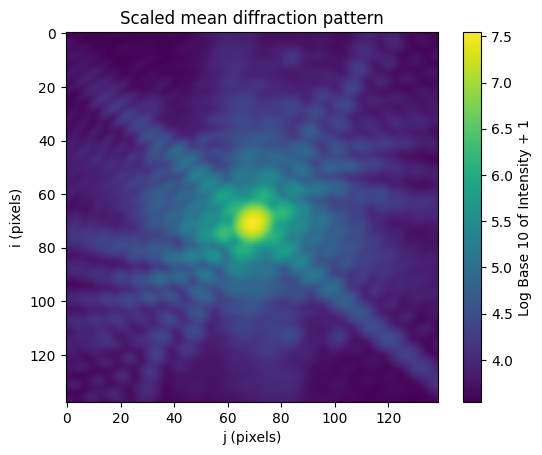

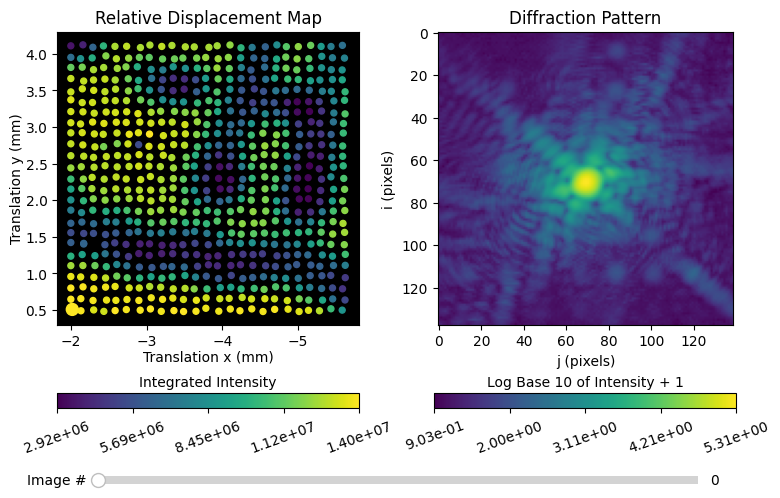

In [5]:
lab_pinhole_dataset = cdtools.datasets.Ptycho2DDataset.from_cxi(
    tutorial_data_folder + 'lab_ptycho_data.cxi')
lab_pinhole_dataset.inspect(units='mm')
plt.show()

Initializing a model
--------------------

The next step in running a ptychograhy reconstruction is to initialize a model. This
initialization step is *very* important, because often a good initialization is the
difference between a good reconstruction and a reconstruction which does not even
converge.

In cdtools, a `CDIModel` is an object which stores all the parameters which will be
reconstructed - the object, probe, and additional error correction terms - and also
contains the key functions which can simulate diffraction data from those parameters.

The standard workhorse model for ptychography reconstructions is the `FancyPtycho` model.
Let's see now how to initialize a model from a loaded dataset, using the gold ball
ptychography data as an example:

In [6]:
# Initialize the model
au_balls_model = cdtools.models.FancyPtycho.from_dataset(au_balls_dataset)

Easy! But, how do we know what this initial state looks like? Well, we can inspect it by
using the `model.inspect(dataset)` function. This will prepare many plots showing us the current
state of all the relevant parameters and error correction terms. Watch out for all the plots!

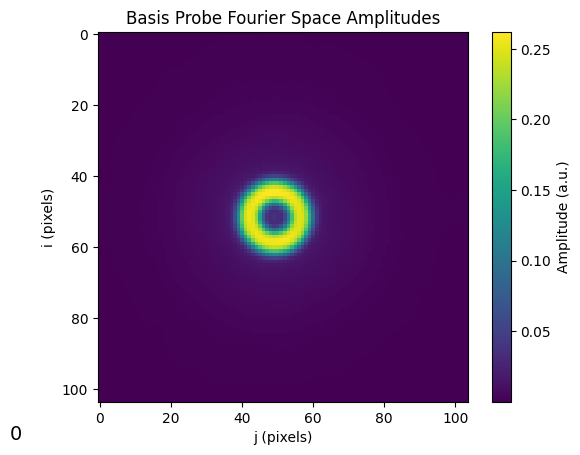

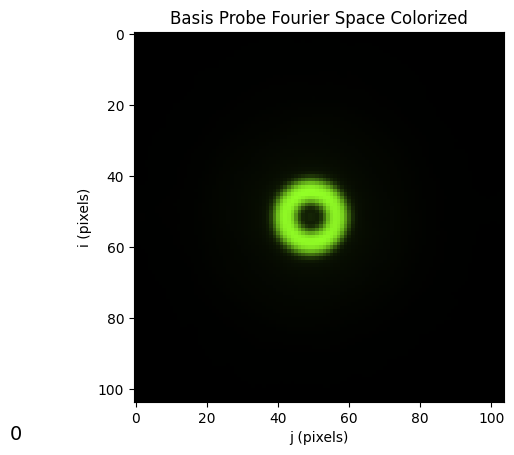

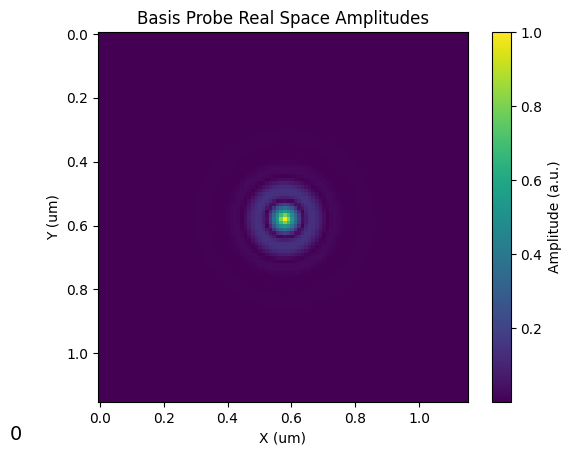

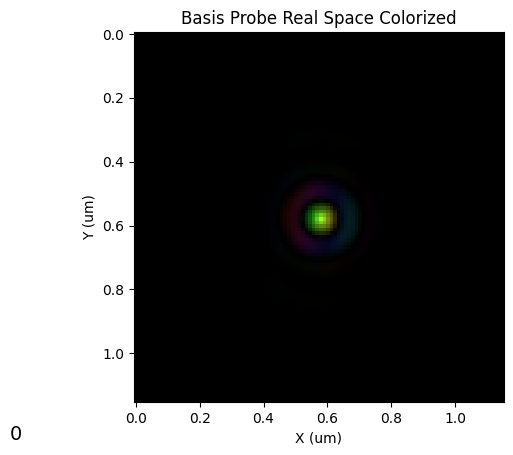

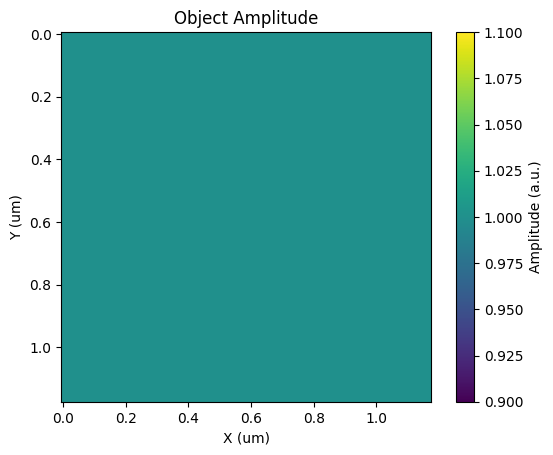

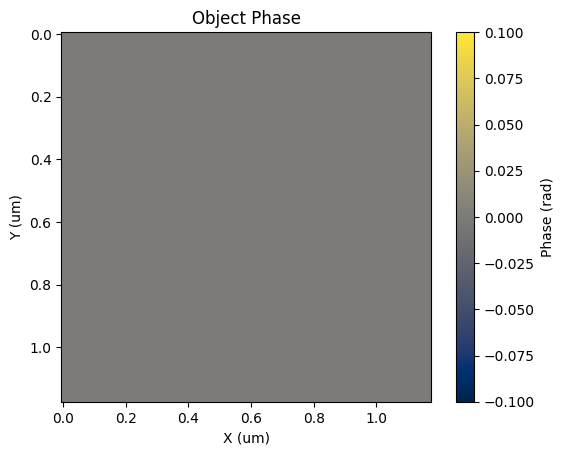

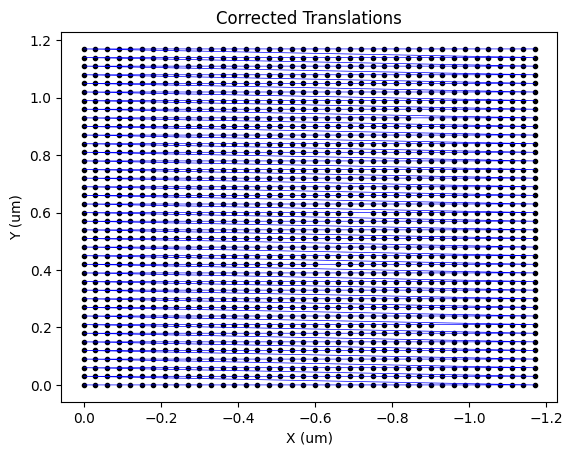

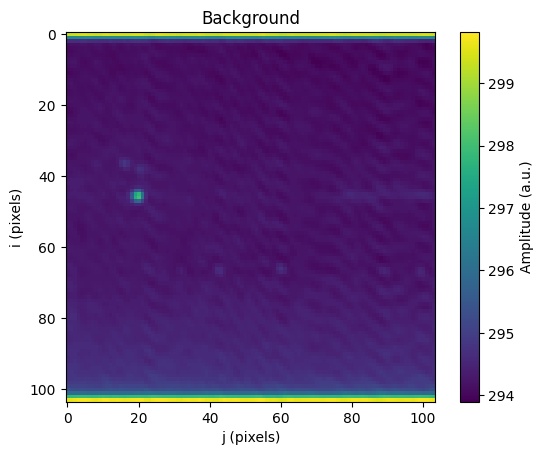

In [7]:
au_balls_model.inspect(au_balls_dataset)
plt.show()

Okay, let's run through all those plots! We just saw:

* The illumination function, plotted both in Fourier space and in real space. The "amplitude" plot shows the amplitude, and the "colorized" plot also shows phase as hue. This is automatically initialized based on the diffraction data.
* The object's amplitude and phase. The object is initialized to a uniform value of 1
* The corrected translations. By default, FancyPtycho will attempt to recover accurate positions during the reconstruction process, and this lets us follow the progress
* The detector background. In this case, it is loaded from the dataset, but if no background information is included in the dataset, then it will be refined during the reconstruction as well

If you're new to ptychography, this may be overwhelming - if you're more familiar, it may seem like old hat. In either case, let's now do some refinement, and see what happens!

Running a reconstruction
------------------------

To run a reconstruction, we use the generator function `model.Adam_optimize(dataset)`.
After each epoch (every time that each diffraction pattern is visited by the algorithm), 
this generator yields control back to the outer loop, and we can print out a report to
follow the loss function.

In an interactive shell, it is possible to update the plots and follow a reconstruction's
progress live. This is a blessing and a curse - it can help quite a bit with debugging, but
it can also take up all the time you should have spent doing other work while you let the
reconstruction run by itself. A watched reconstruction never converges.

Finally, the reconstruction will run much faster on the GPU. To use the gpu, we move
the model and dataset to the GPU. simple as!

In [8]:
# We move the model to the GPU
device = 'cuda'
au_balls_model.to(device=device)
au_balls_dataset.get_as(device=device)

# We run the actual reconstruction
for loss in au_balls_model.Adam_optimize(50, au_balls_dataset, batch_size=10):
    # We print a quick report of the optimization status
    print(au_balls_model.report())
    # If desired, liveplot the updates to the model as they happen.
    # DO NOT UNCOMMENT THIS IN A JUPYTER NOTEBOOK, it will make you unhappy
    ####### model.inspect(dataset)

Epoch   1 completed in 3.01 s with loss 1.60002e-03
Epoch   2 completed in 1.04 s with loss 3.01609e-03
Epoch   3 completed in 1.00 s with loss 2.15204e-03
Epoch   4 completed in 1.06 s with loss 2.04585e-03
Epoch   5 completed in 1.08 s with loss 1.79137e-03
Epoch   6 completed in 1.04 s with loss 1.63642e-03
Epoch   7 completed in 1.01 s with loss 1.71283e-03
Epoch   8 completed in 1.03 s with loss 1.85878e-03
Epoch   9 completed in 1.04 s with loss 2.00194e-03
Epoch  10 completed in 1.02 s with loss 1.90532e-03
Epoch  11 completed in 1.02 s with loss 1.88200e-03
Epoch  12 completed in 1.06 s with loss 1.88577e-03
Epoch  13 completed in 1.07 s with loss 1.86162e-03
Epoch  14 completed in 1.01 s with loss 1.93287e-03
Epoch  15 completed in 1.00 s with loss 1.98108e-03
Epoch  16 completed in 0.99 s with loss 1.84529e-03
Epoch  17 completed in 0.97 s with loss 1.72941e-03
Epoch  18 completed in 0.96 s with loss 1.68544e-03
Epoch  19 completed in 0.95 s with loss 1.76349e-03
Epoch  20 co

This just ran 100 iterations of an automatic differentiation based reconstruction algorithm
which uses the Adam optimizer to take update steps. In this case, the default step size is
quite large, so if you follow the loss metrics, you will notice that they don't uniformly drop.
This can be good at the start of a reconstruction, but it also means that we will not converge
to a good result in the end. We therefore may eventually want to *chain* several algorithms,
in order to first converge quickly to a reasonable result, before finally dialing in to a high
quality result with a differently tuned algorithm.

Let's see what this first algorithm did, though:

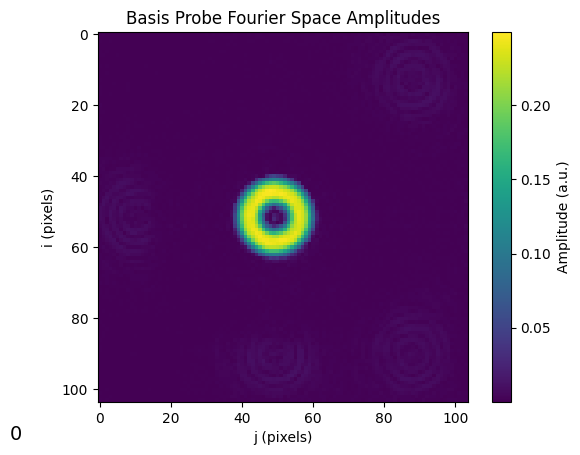

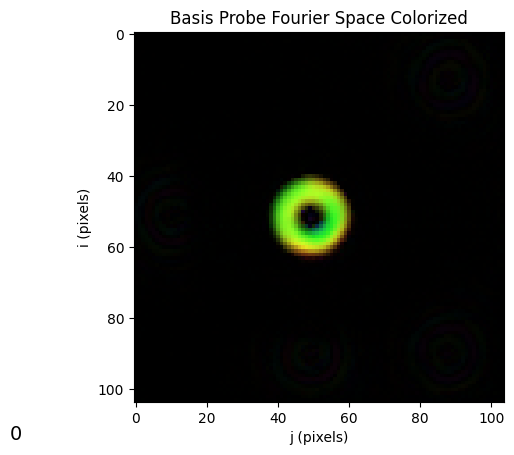

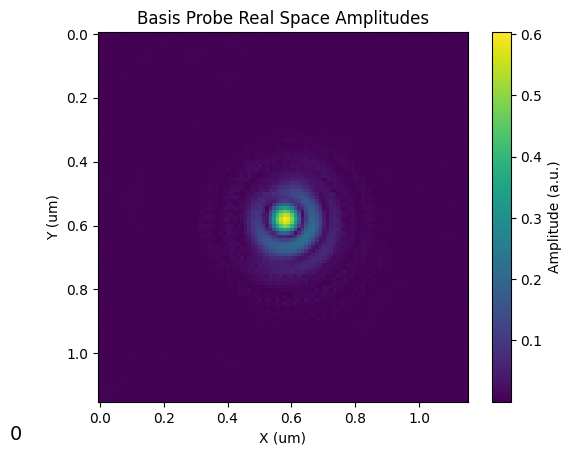

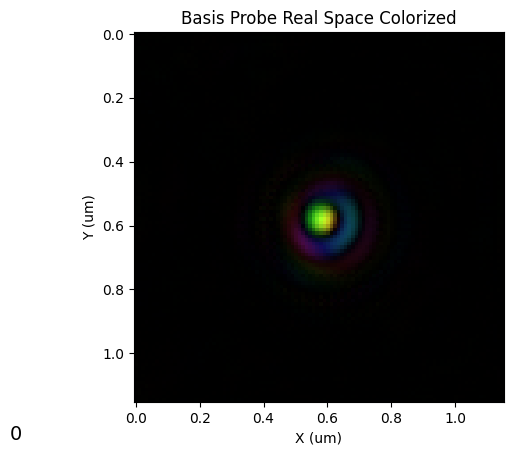

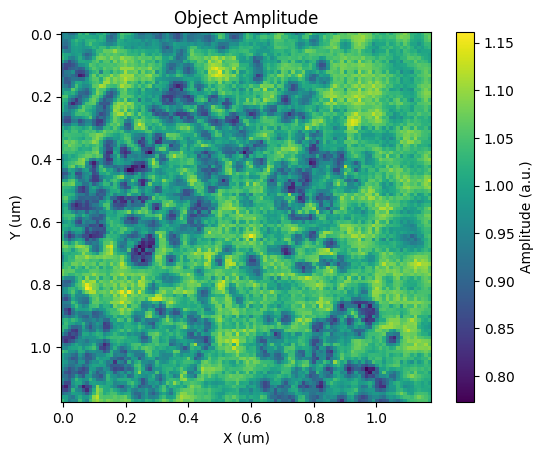

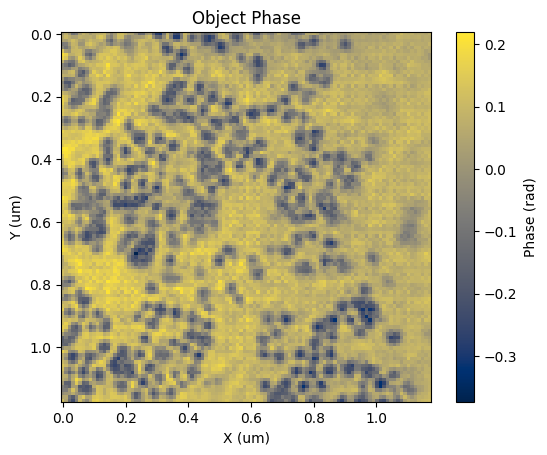

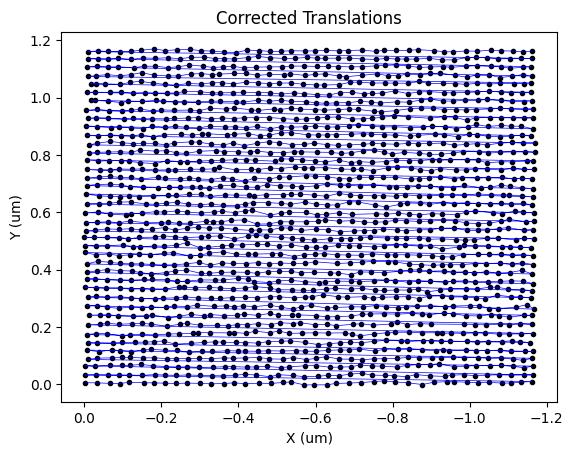

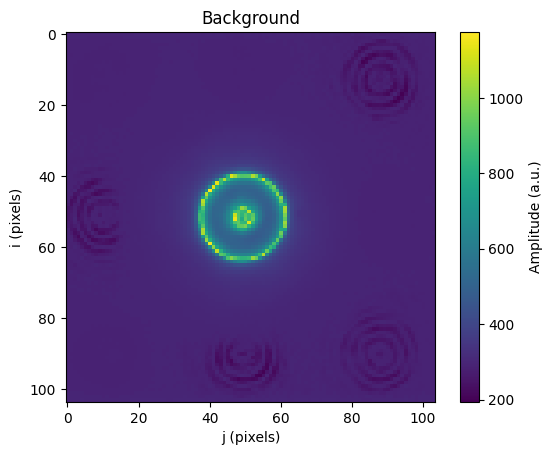

In [9]:
au_balls_model.inspect(au_balls_dataset)
plt.show()

Let's go through each of the parameters, one-by-one:
* The probe looks quite similar, but note that the real-space probe has grown slightly from the initial guess, and in both real and Fourier space, some slight phase structure can be seen which was not present before
* The object now shows an image of the gold balls, but it has a grid-like pattern overlayed, and there is lots of noise in general. The image is still quite noisy
* The refined translation positions are all over the place. Much of this is simply jitter in the reconstruction algorithm, but a slight overall shear (which is real) can also be seen.
* The background now also includes an image of a donut. This is additional scattering from the zone plate which is not interfering with the main, coherent illumination mode. How cool is that!


Improving the Reconstruction
----------------------------

We can improve this reconstruction in a few ways! Naturally, we can improve the reconstruction
by changing the reconstruction algorithm, as discussed above, but we can also make progress
by improving the initialization for the algorithm. Let's do that now!

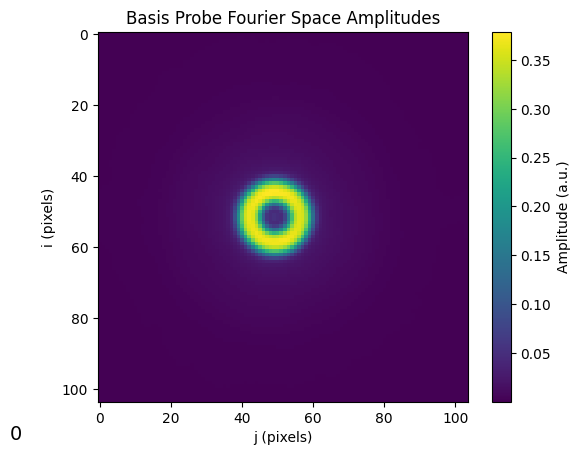

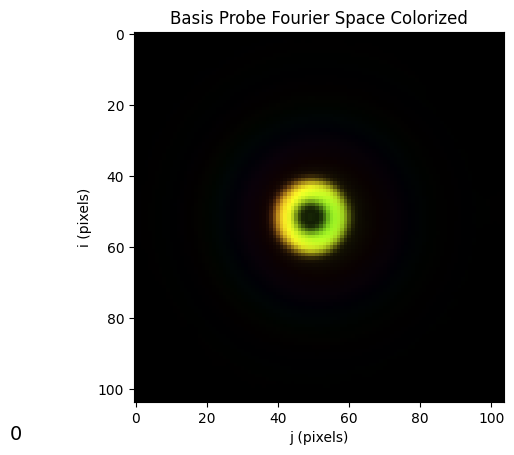

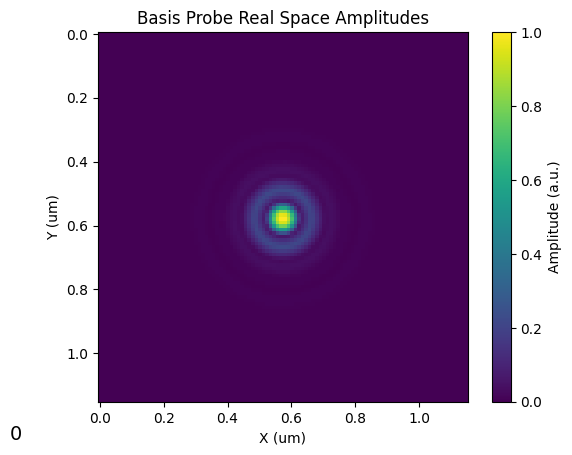

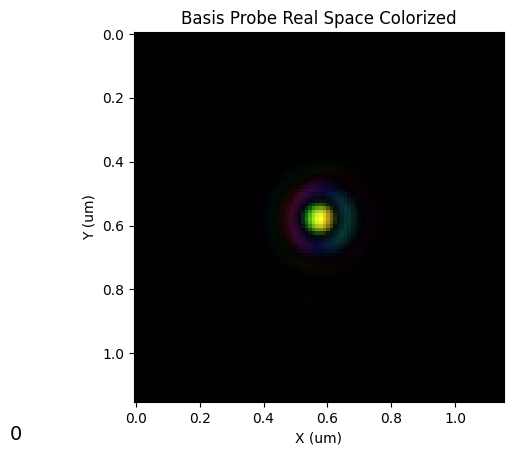

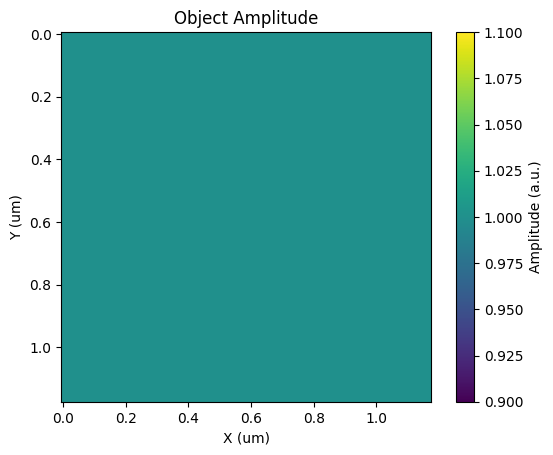

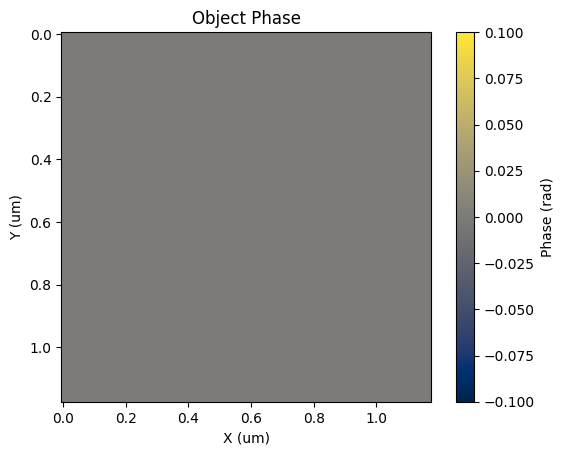

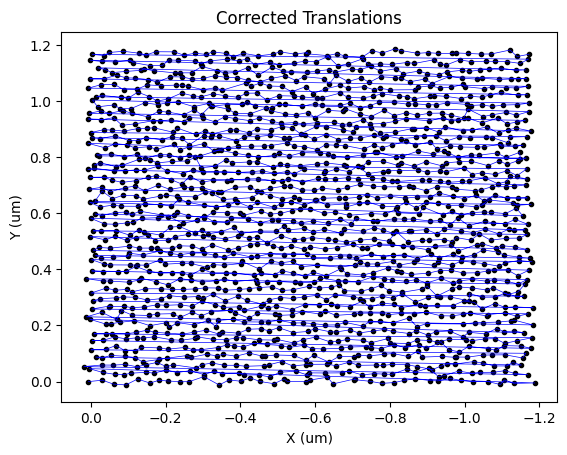

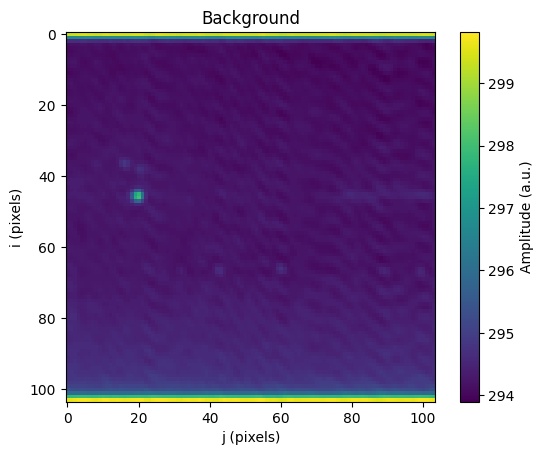

In [10]:
au_balls_model_2 = cdtools.models.FancyPtycho.from_dataset(
    au_balls_dataset,
    n_modes=3, # Use multi-mode ptycho with 3 modes
    probe_support_radius=50, # Constrain the probe to a 50-pixel diameter region
    propagation_distance=2e-6, # Initialize the probe to a guess set 20 um downstream from focus
    units='um', # Plot everything in units of microns
)

# This trick introduces a bit of jitter to the probe positions. It helps remove the
# grid-like structure which was present in the initial reconstruction.
# Try running this script with and without this line to see the difference!
au_balls_model_2.translation_offsets.data += \
    0.7 * t.randn_like(au_balls_model_2.translation_offsets)

# This turns off a refinement parameter for a varying probe intensity, which is not needed
# in this dataset. Turning it off can improve results when it is not needed.
au_balls_model_2.weights.requires_grad = False

au_balls_model_2.inspect(au_balls_dataset)
plt.show()

So, what looks different? Well, two things jump out immediately:

* The probe is slightly larger in real space, because we added a propagation distance. This mirrors what we saw happen to the probe in our initial reconstruction
* The positions are all jittery now, as we planned!

Let's see what this does in a reconstruction, where now we also explicitly set the learning
rate (lr) and minibatch size (batch_size) to adjust the aggressiveness of the reconstruction:

Epoch   1 completed in 0.91 s with loss 3.12136e-03
Epoch   2 completed in 0.89 s with loss 8.63807e-04
Epoch   3 completed in 0.93 s with loss 6.71758e-04
Epoch   4 completed in 0.89 s with loss 5.72840e-04
Epoch   5 completed in 0.89 s with loss 5.06831e-04
Epoch   6 completed in 0.88 s with loss 4.65023e-04
Epoch   7 completed in 0.88 s with loss 4.12263e-04
Epoch   8 completed in 0.93 s with loss 3.75508e-04
Epoch   9 completed in 0.86 s with loss 3.50333e-04
Epoch  10 completed in 0.87 s with loss 3.33377e-04
Epoch  11 completed in 0.94 s with loss 3.15548e-04
Epoch  12 completed in 0.88 s with loss 3.07435e-04
Epoch  13 completed in 0.90 s with loss 2.94384e-04
Epoch  14 completed in 0.89 s with loss 2.80989e-04
Epoch  15 completed in 0.90 s with loss 2.76122e-04
Epoch  16 completed in 0.87 s with loss 2.64233e-04
Epoch  17 completed in 0.87 s with loss 2.51865e-04
Epoch  18 completed in 0.87 s with loss 2.41764e-04
Epoch  19 completed in 0.87 s with loss 2.33143e-04
Epoch  20 co

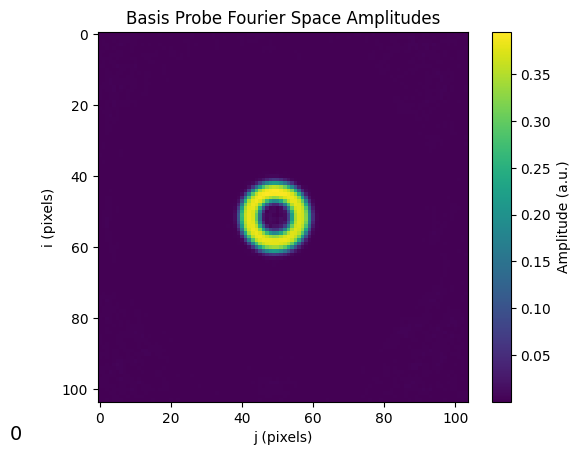

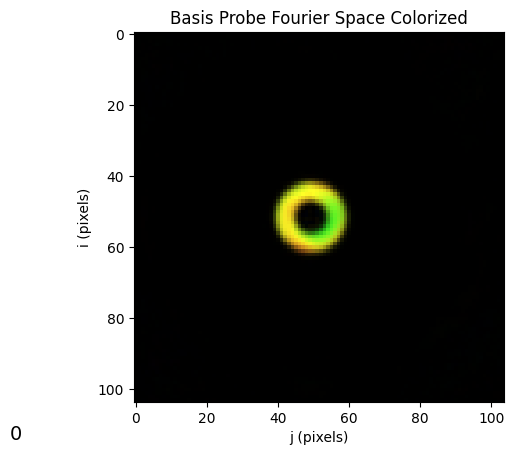

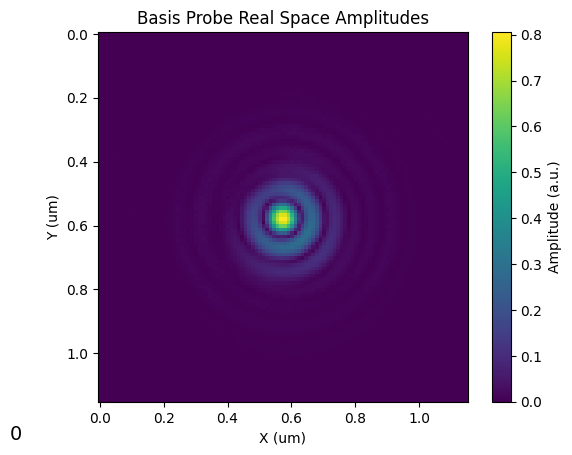

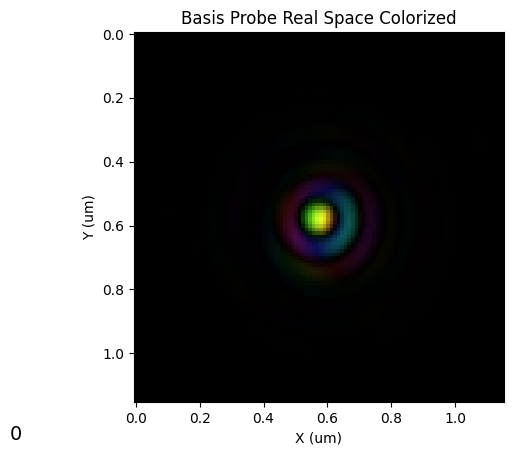

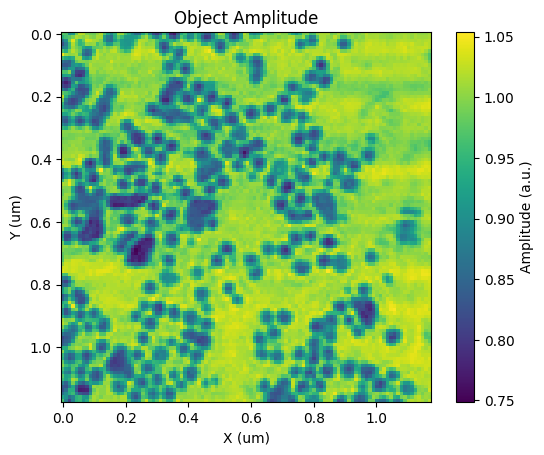

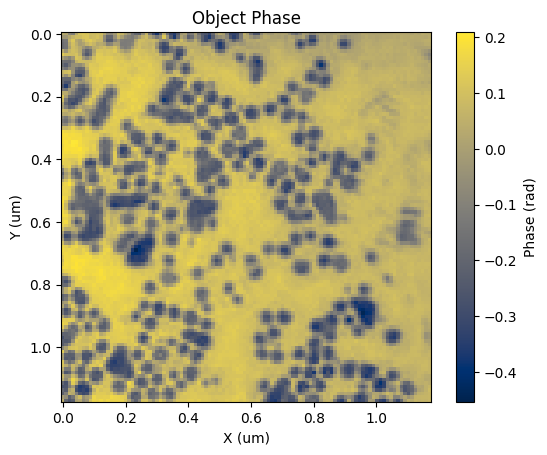

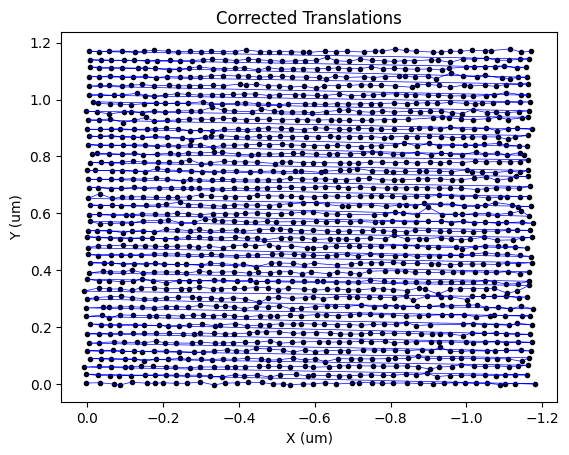

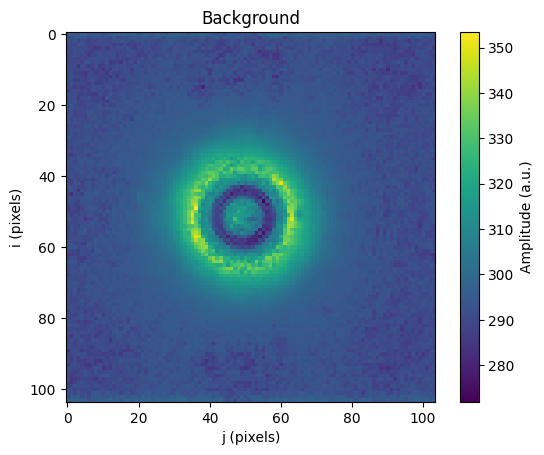

In [11]:
# We move the model to the GPU
device = 'cuda'
au_balls_model_2.to(device=device)
au_balls_dataset.get_as(device=device)

# A very coarse initial search
for loss in au_balls_model_2.Adam_optimize(20, au_balls_dataset, lr=0.005, batch_size=50):
    print(au_balls_model_2.report())

# A medium-aggressive refinement
for loss in au_balls_model_2.Adam_optimize(50, au_balls_dataset, lr=0.002, batch_size=100):
    print(au_balls_model_2.report())

au_balls_model_2.inspect(au_balls_dataset)
plt.show()

Note, before anything else, how the loss metric almost immediately improved by an order of
magnitude! The loss metric can be misleading, but in this case, it shows that we have done
a much better job of capturing the details of the true data.

But, additionally, note the following changes in the recovered parameters:
* The grid pattern is gone and the objects look much less noisy, although artifacts are still present
* The positions are much less jittery than in the initialization - they have started to find the true positions
* The background is much less intense. This is because we added additional probe modes, which accounts for incoherence in the probe. This incoherence is what the background of our first refinement was capturing.

This looks good, but we can do better - let's do a final round for a best-quality refinement. In this round, we use "schedule=True", to allow the optimizer to lower the learning rate
if the loss has plateaued.

In [ ]:
for loss in au_balls_model_2.Adam_optimize(100, au_balls_dataset, lr=0.001, batch_size=100,
                                schedule=True):
    print(au_balls_model_2.report())

au_balls_model_2.tidy_probes()

au_balls_model_2.inspect(au_balls_dataset)
plt.show()

Epoch  71 completed in 0.88 s with loss 2.03023e-04
Epoch  72 completed in 0.91 s with loss 1.28705e-04
Epoch  73 completed in 0.88 s with loss 1.16236e-04
Epoch  74 completed in 0.90 s with loss 1.14497e-04
Epoch  75 completed in 0.92 s with loss 1.13738e-04
Epoch  76 completed in 0.88 s with loss 1.13685e-04
Epoch  77 completed in 0.86 s with loss 1.13393e-04
Epoch  78 completed in 0.89 s with loss 1.13184e-04
Epoch  79 completed in 0.87 s with loss 1.12933e-04
Epoch  80 completed in 0.89 s with loss 1.13021e-04
Epoch  81 completed in 0.86 s with loss 1.12721e-04
Epoch  82 completed in 0.86 s with loss 1.13415e-04
Epoch  83 completed in 0.87 s with loss 1.12602e-04
Epoch  84 completed in 0.90 s with loss 1.12423e-04
Epoch  85 completed in 0.88 s with loss 1.12270e-04
Epoch  86 completed in 0.88 s with loss 1.12215e-04
Epoch  87 completed in 0.87 s with loss 1.11656e-04
Epoch  88 completed in 0.90 s with loss 1.11677e-04
Epoch  89 completed in 0.87 s with loss 1.11085e-04
Epoch  90 co

Note here that, before plotting the results this time, we ran the function
`model.tidy_probes()`. This function orthogonalizes the recovered probe modes. This is a fancy
way of saying that we adjusted the recovered illumination function in a way which generates
a physically equivalent probe, but which is expressed in a unique way which is suitable for
comparison with other reconstructions. It is good to run this function once, after the entire
reconstruction is complete

At this stage, we can say we're done, but we have one final thing to look at! This is the
comparison of the simulated data (using the recovered object, probe, etc) with the measured
raw data. This is not always needed, but it can be an excellent tool for debugging, or for
discovering (for example) that your reconstruction has totally not converged yet.

We use the following line, and again, note that this works much better in a script or
an interactive terminal:

In [ ]:
au_balls_model_2.compare(au_balls_dataset)
plt.show()

Finally, we need to save the results. We do that in the following way. Note that, at COSMIC
Imaging, they tend to use '.mat' files, and thus have a slightly different workflow for saving
results.

In [ ]:
au_balls_model_2.save_to_h5('au_balls_reconstruction_tutorial.h5', au_balls_dataset)

Now it's your turn
------------------

Try running a reconstruction on the pinhole based ptycho data! Remember that we loaded the data under `lab_pinhole_dataset`

A working reconstruction script is included in a final cell, if you need it to get oriented.
I believe in you, though. You can get a reconstruction on your own!

In [ ]:
# Write a reconstruction script here

In [ ]:
# And another free cell, why not

Spoilers below
--------------

For those who look: the reconstruction script below uses some features which I did not discuss above. It is absolutely possible to get a good reconstruction without these features, although
they improve the quality.

Happy reconstructing! And don't forget - there are more tutorials and example scripts available
available at the [documentation page](https://cdtools-developers.github.io/cdtools/) and [github page](https://github.com/cdtools-developers/cdtools) for the project.

In [ ]:
# Spoilers!
lab_pinhole_model = cdtools.models.FancyPtycho.from_dataset(
    lab_pinhole_dataset,
    n_modes=3, # Use 3 incoherently mixing probe modes
    oversampling=2, # Simulate the probe on a 2xlarger real-space array
    probe_support_radius=120, # Force the probe to 0 outside a radius of 120 pix
    propagation_distance=5e-3, # Propagate the initial probe guess by 5 mm
    units='mm', # Set the units for the live plots
    obj_view_crop=-50, # Expands the field of view in the object plot by 50 pix
)

device = 'cuda'
lab_pinhole_model.to(device=device)
lab_pinhole_dataset.get_as(device=device)

for loss in lab_pinhole_model.Adam_optimize(50, lab_pinhole_dataset, lr=0.02, batch_size=10):
    print(lab_pinhole_model.report())
    
for loss in lab_pinhole_model.Adam_optimize(50, lab_pinhole_dataset,  lr=0.005, batch_size=50):
    print(lab_pinhole_model.report())

# This orthogonalizes the recovered probe modes
lab_pinhole_model.tidy_probes()

lab_pinhole_model.inspect(lab_pinhole_dataset)
plt.show()